In [1]:
# Imports, paths e seed

import os, json, math, platform, warnings, time
from pathlib import Path
from datetime import datetime
from datetime import timezone
from itertools import product
from typing import List, Dict, Any

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel

BASE = Path("../../data")
IN_CSV = BASE/"interim"/"bertopic"/"prep.csv"
OUT_DIR = BASE/"processed"/"bertopic"
FIGS = Path("../../reports/figs")

OUT_DIR.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

SEED = 42
np.random.seed(SEED)

def _get_ver(pkg):
    try:
        import importlib.metadata as im
        return im.version(pkg)
    except Exception:
        return "NA"

versions = {
    "python": platform.python_version(),
    "bertopic": _get_ver("bertopic"),
    "sentence-transformers": _get_ver("sentence-transformers"),
    "umap-learn": _get_ver("umap-learn"),
    "hdbscan": _get_ver("hdbscan"),
    "scikit-learn": _get_ver("scikit-learn"),
    "gensim": _get_ver("gensim"),
    "numpy": _get_ver("numpy"),
    "pandas": _get_ver("pandas")
}
print("VERSIONS:", json.dumps(versions, indent=2, ensure_ascii=False))

VERSIONS: {
  "python": "3.12.2",
  "bertopic": "0.16.0",
  "sentence-transformers": "2.6.1",
  "umap-learn": "0.5.6",
  "hdbscan": "0.8.33",
  "scikit-learn": "1.4.2",
  "gensim": "4.3.3",
  "numpy": "1.26.4",
  "pandas": "2.2.2"
}


In [2]:
# Stopwords em português (para CountVectorizer)
try:
    from nltk.corpus import stopwords as nltk_stop
    STOP_WORDS_PT = sorted(set(nltk_stop.words('portuguese')))
    print(f"STOP_WORDS_PT carregadas: {len(STOP_WORDS_PT)} termos")
except Exception as e:
    # fallback mínimo para não travar caso NLTK falhe (mantém pipeline funcionando)
    print("[WARN] NLTK indisponível; usando fallback reduzido:", e)
    STOP_WORDS_PT = sorted(set("""
a à acerca agora ai ainda além algo alguem alguns algumas algum alguma ambos ambas ante antes ao aos após aquela aquelas aquele aqueles aquilo as assim até através cada quase com como contra contudo cujo cuja cujos cujas da das de dela delas dele deles depois desde desta deste disso disto do dos e é ela elas ele eles em entre era eram essa essas esse esses esta estas este estes estou eu foi foram fosse fossem fui há isso isto já la lá lhe lhes mais mas me mesmo mesmoa mesmos mesmas minha minhas meu meus muito muita muitas muitos não na nas nem no nos nós o os ou para pela pelas pelo pelos pouca poucas pouco poucos por porque porém pra qual quais quando que quem se sem sempre sendo ser seu seus sob sobre sua suas também tão tão tem tenho ter teu teus tua tuas tudo um uma umas uns
""".split()))

STOP_WORDS_PT carregadas: 207 termos


In [3]:
# Leitura e preparação dos textos

df = pd.read_csv(IN_CSV, encoding="utf-8")

required_cols = {"DOC_ID", "resumo", "RESUMO_PREP_BERTOPIC"}
missing = required_cols - set(df.columns)
assert not missing, f"Colunas ausentes: {missing}"

docs_for_embeddings = (
    df["resumo"].fillna(df["RESUMO_PREP_BERTOPIC"]).astype(str).tolist()
)
docs_for_vectorizer = (
    df["RESUMO_PREP_BERTOPIC"].fillna("").astype(str).tolist()
)

lens = pd.Series([len(x) for x in docs_for_vectorizer])
print("N documentos:", len(df))
print("Docs vazios (vectorizer):", sum([len(x.strip()) == 0 for x in docs_for_vectorizer]))
print("Comprimento (chars) — quantis:", lens.quantile([0.0, 0.25, 0.5, 0.75, 0.95, 1.0]).to_dict())


N documentos: 423
Docs vazios (vectorizer): 14
Comprimento (chars) — quantis: {0.0: 0.0, 0.25: 894.5, 0.5: 1123.0, 0.75: 1322.5, 0.95: 1729.2999999999997, 1.0: 2309.0}


In [4]:
# Embeddings (SBERT)

# Modelo multilíngue leve que preserva semântica de sentenças (SBERT)
# BERT → base dos embeddings contextuais [Devlin et al.] usados em SBERT
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
sbert_name = "paraphrase-multilingual-MiniLM-L12-v2"

start = time.time()
sbert = SentenceTransformer(sbert_name, device=device)
embeddings = sbert.encode(
    docs_for_embeddings,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True
)
elapsed = time.time() - start
print(f"Embeddings shape={embeddings.shape} | device={device} | time={elapsed:.1f}s")


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings shape=(423, 384) | device=cpu | time=11.5s


In [5]:
# Grade de hiperparâmetros (mini-sweep)

from math import floor
N_DOCS = len(docs_for_vectorizer)

# === EXPANDE A GRADE PARA MAIS GRANULARIDADE ===
grid_umap = {
    "n_neighbors": [5, 10, 15, 30],
    "n_components": [5, 10, 15],
    "min_dist": [0.0],
    "metric": ["cosine"],
    "random_state": [SEED],
}

grid_hdb = {
    "min_cluster_size": [5, 8, 10, 15],
    "min_samples": [1, 5, None],
    "metric": ["euclidean"],
    "cluster_selection_method": ["eom", "leaf"],  # incluímos 'leaf' para granularidade
    "prediction_data": [True],
}

grid_vec = {
    "ngram_range": [(1,1), (1,2), (1,3)],
    "stop_words": [STOP_WORDS_PT],
    "min_df": [1, 2, 3],
    "max_df": [0.95, 0.99],
}

# Produto cartesiano (com UMAP)
from itertools import product
combos_all = []
for u, h, v in product(
    product(*grid_umap.values()),
    product(*grid_hdb.values()),
    product(*grid_vec.values())
):
    umap_kwargs = dict(zip(grid_umap.keys(), u))
    hdb_kwargs = dict(zip(grid_hdb.keys(), h))
    vec_kwargs = dict(zip(grid_vec.keys(), v))
    combos_all.append({"umap": umap_kwargs, "hdb": hdb_kwargs, "vec": vec_kwargs})

# Baseline (a mesma da sua versão anterior)
baseline = {
    "umap": {"n_neighbors": 10, "n_components": 5, "min_dist": 0.0, "metric": "cosine", "random_state": SEED},
    "hdb": {"min_cluster_size": 10, "min_samples": None, "metric": "euclidean",
            "cluster_selection_method": "eom", "prediction_data": True},
    "vec": {"ngram_range": (1,1), "stop_words": STOP_WORDS_PT, "min_df": 2, "max_df": 0.9},
}

def _same(a, b): 
    return json.dumps(a, sort_keys=True) == json.dumps(b, sort_keys=True)

combos = [baseline] + [c for c in combos_all if not _same(c, baseline)]

# ---- filtro para evitar "max_df corresponds to < documents than min_df"
def _valid_vec(v, n_docs: int) -> bool:
    min_df = v["min_df"]
    max_df = v["max_df"]
    max_docs = floor(max_df * n_docs) if isinstance(max_df, float) else int(max_df)
    return max_docs >= int(min_df)

combos = [c for c in combos if _valid_vec(c["vec"], N_DOCS)]

# === Amostragem reprodutível para conter o tamanho do sweep ===
# Mantemos baseline + 39 aleatórios (total 40)
N_MAX = 40
rng = np.random.RandomState(SEED)
if len(combos) > N_MAX:
    others = combos[1:]
    idx = rng.choice(len(others), size=N_MAX-1, replace=False)
    combos = [combos[0]] + [others[i] for i in sorted(idx)]

# === LOTE DE CONTROLE "SEM UMAP" (opcional, pequeno) ===
# Gera combos onde 'umap' é None (HDBSCAN direto nos embeddings)
combos_noumap_all = []
for h, v in product(
    product(*grid_hdb.values()),
    product(*grid_vec.values())
):
    hdb_kwargs = dict(zip(grid_hdb.keys(), h))
    vec_kwargs = dict(zip(grid_vec.keys(), v))
    combos_noumap_all.append({"umap": None, "hdb": hdb_kwargs, "vec": vec_kwargs})

# Aplica o mesmo filtro de min_df/max_df
combos_noumap_all = [c for c in combos_noumap_all if _valid_vec(c["vec"], N_DOCS)]

# Mescla uma pequena amostra (até 10) de combos sem UMAP
take = min(10, len(combos_noumap_all))
idx_nu = rng.choice(len(combos_noumap_all), size=take, replace=False) if take > 0 else []
combos = combos + [combos_noumap_all[i] for i in sorted(idx_nu)]

# Se passou de N_MAX, reamostra mantendo baseline na frente
if len(combos) > N_MAX:
    others = combos[1:]
    # escolhe N_MAX-1 dentre o restante (com UMAP e sem UMAP misturados)
    idx = rng.choice(len(others), size=N_MAX-1, replace=False)
    combos = [combos[0]] + [others[i] for i in sorted(idx)]

print(f"Combos válidos após filtro/amostragem (incluindo sem UMAP): {len(combos)}")
print("Exemplo (0):", combos[0])

Combos válidos após filtro/amostragem (incluindo sem UMAP): 40
Exemplo (0): {'umap': {'n_neighbors': 10, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine', 'random_state': 42}, 'hdb': {'min_cluster_size': 10, 'min_samples': None, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}, 'vec': {'ngram_range': (1, 1), 'stop_words': ['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estar', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'form

In [6]:
# Funções auxiliares

def write_json(path: Path, data: Dict[str, Any]):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

def extract_topic_words(topic_model: BERTopic, topk: int = 10) -> List[List[str]]:
    topics_dict = topic_model.get_topics()
    topic_words: List[List[str]] = []
    for tid, pairs in topics_dict.items():
        if tid == -1:
            continue
        # BERTopic pode retornar None/[] para tópicos degenerados
        if not pairs:
            continue
        # Garante apenas strings não vazias; respeita topk
        toks = [str(w).strip() for (w, _) in pairs[:topk] if isinstance(w, (str, bytes)) and str(w).strip()]
        if toks:
            topic_words.append(toks)
    return topic_words

def simple_tokenize_docs(docs: List[str]) -> List[List[str]]:
    # Tokenização simples coerente com o CountVectorizer (lower/space)
    return [str(d).lower().split() for d in docs]

def topic_diversity(topic_words: List[List[str]], topk: int = 10) -> float:
    if not topic_words:
        return float("nan")
    uniq = len(set([w for tw in topic_words for w in tw[:topk]]))
    return uniq / (topk * len(topic_words))

def outlier_rate(topics: List[int]) -> float:
    topics = np.array(topics)
    return float(np.mean(topics == -1))

def _sanitize_topics_for_gensim(topic_words: List[List[str]]) -> List[List[str]]:
    clean: List[List[str]] = []
    for tw in topic_words:
        if not isinstance(tw, (list, tuple)):
            continue
        toks = [str(t).strip() for t in tw if isinstance(t, (str, bytes)) and str(t).strip()]
        if toks:
            clean.append(toks)
    return clean

def compute_coherences(topic_words, tokenized_docs):
    # c_npmi e c_uci com 'texts' (ambas aceitam texts); sanear antes de passar ao gensim
    from gensim.corpora import Dictionary
    from gensim.models.coherencemodel import CoherenceModel

    cleaned = _sanitize_topics_for_gensim(topic_words)
    if not cleaned:
        return float("nan"), float("nan")

    dictionary = Dictionary(tokenized_docs)

    c_npmi = CoherenceModel(
        topics=cleaned, texts=tokenized_docs, dictionary=dictionary, coherence="c_npmi"
    ).get_coherence()

    c_uci = CoherenceModel(
        topics=cleaned, texts=tokenized_docs, dictionary=dictionary, coherence="c_uci"
    ).get_coherence()

    return float(c_npmi), float(c_uci)

In [7]:
# Loop do sweep: treino, avaliação e salvamento por trial

# === Isolamento por execução: salva em subpasta RUN_ID ===
RUN_ID = datetime.now(timezone.utc).strftime("run_%Y%m%dT%H%M%SZ")
RUN_DIR = OUT_DIR / RUN_ID
RUN_DIR.mkdir(parents=True, exist_ok=True)
write_json(RUN_DIR/"run_info.json", {
    "run_id": RUN_ID, "seed": SEED, "versions": versions,
    "n_docs": len(docs_for_vectorizer), "timestamp_utc": datetime.now(timezone.utc).isoformat()
})

tokenized_docs = simple_tokenize_docs(docs_for_vectorizer)
trials_summary = []
errors_log = []

N_DOCS_EFF = len(docs_for_vectorizer)  # usado para sanear min_df/max_df

for i, cfg in enumerate(tqdm(combos, desc="Sweep")):
    trial_id = f"trial_{i:02d}"
    tdir = RUN_DIR / trial_id
    tdir.mkdir(parents=True, exist_ok=True)

    # --- SANEAMENTO do Vectorizer (evita "max_df corresponds to < documents than min_df" e string 'portuguese')
    vec_kwargs = cfg["vec"].copy()
    sw = vec_kwargs.get("stop_words", None)
    if isinstance(sw, str):
        vec_kwargs["stop_words"] = STOP_WORDS_PT

    min_df = vec_kwargs.get("min_df", 1)
    max_df = vec_kwargs.get("max_df", 1.0)
    min_df_prop = (min_df / max(N_DOCS_EFF, 1)) if isinstance(min_df, int) else float(min_df)
    max_df_prop = (max_df / max(N_DOCS_EFF, 1)) if isinstance(max_df, int) else float(max_df)
    if max_df_prop < min_df_prop:
        max_df_prop = min(1.0, max(min_df_prop + 1e-9, 0.999))
    vec_kwargs["min_df"] = min_df_prop
    vec_kwargs["max_df"] = max_df_prop

    # Instâncias dos componentes
    vectorizer_model = CountVectorizer(**vec_kwargs)
    # >>> CORREÇÃO: aceitar combos "sem UMAP"
    umap_model = None if (cfg["umap"] is None) else UMAP(**cfg["umap"])
    hdbscan_model = HDBSCAN(**cfg["hdb"])

    topic_model = BERTopic(
        embedding_model=None,
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,          # pode ser None
        hdbscan_model=hdbscan_model,
        calculate_probabilities=True,
        verbose=False
    )

    started = datetime.now(timezone.utc).isoformat()
    t0 = time.time()
    try:
        topics, probs = topic_model.fit_transform(
            documents=docs_for_vectorizer,
            embeddings=embeddings
        )
        fit_time = time.time() - t0

        # Artefatos primários
        topic_info = topic_model.get_topic_info()
        topic_info.to_csv(tdir/"topic_info.csv", index=False, encoding="utf-8")

        # Doc→tópico
        if probs is not None and hasattr(probs, "__array__"):
            rowmax = np.nanmax(probs, axis=1)
            doc_prob = [float(x) if np.isfinite(x) else np.nan for x in rowmax]
        else:
            doc_prob = [np.nan] * len(topics)

        doc_topics = pd.DataFrame({
            "DOC_ID": df["DOC_ID"].values,
            "topic": topics,
            "prob": doc_prob
        })
        # mantém alt e compatível com o comparador
        doc_topics.to_csv(tdir/"doc_topics_alt.csv", index=False, encoding="utf-8")
        doc_topics.to_csv(tdir/"doc_topics.csv", index=False, encoding="utf-8")

        # c-TF-IDF e vocabulário
        ctf = topic_model.c_tf_idf_
        arr = ctf.toarray() if hasattr(ctf, "toarray") else np.asarray(ctf)
        np.save(tdir/"c_tf_idf.npy", arr)

        vocab = vectorizer_model.get_feature_names_out()
        with open(tdir/"vocab.txt", "w", encoding="utf-8") as f:
            f.write("\n".join(map(str, vocab)))

        # === Métricas (com blindagens) ===
        topic_words = extract_topic_words(topic_model, topk=10)
        div = topic_diversity(topic_words, topk=10)

        # usa a função já definida no notebook (não 'coherence_npmi', que não existe aqui)
        try:
            c_npmi, c_uci = compute_coherences(topic_words, tokenized_docs)
        except Exception as e:
            warnings.warn(f"Coerência falhou em {trial_id}: {e}")
            c_npmi, c_uci = np.nan, np.nan

        # >>> CORREÇÃO: converte para array antes de comparar com -1
        topics_arr = np.asarray(topics)
        out_pct = float(np.mean(topics_arr == -1))

        n_topics_no_outlier = int((topic_info["Topic"] != -1).sum())

        metrics = {
            "c_npmi": c_npmi,
            "c_uci": c_uci,
            "topic_diversity@10": div,
            "outlier_rate": out_pct,
            "n_topics_excl_-1": n_topics_no_outlier,
            "fit_time_sec": fit_time
        }
        write_json(tdir/"metrics.json", metrics)

        # Metadados
        run_md = {
            "trial_id": trial_id,
            "started_utc": started,
            "finished_utc": datetime.now(timezone.utc).isoformat(),
            "seed": SEED,
            "versions": versions,
            "paths": {
                "input_csv": str(IN_CSV.resolve()),
                "trial_dir": str(tdir.resolve())
            },
            "params": {
                "umap": cfg["umap"],
                "hdbscan": cfg["hdb"],
                "vectorizer": {
                    **{k: (list(v) if k=="ngram_range" else v) for k, v in cfg["vec"].items()},
                    "_effective_min_df": vec_kwargs["min_df"],
                    "_effective_max_df": vec_kwargs["max_df"],
                },
                "sbert_model": sbert_name,
            },
            "sizes": {
                "n_docs": len(df),
                "emb_dim": int(embeddings.shape[1])
            }
        }
        write_json(tdir/"run_metadata.json", run_md)

        trials_summary.append({
            "trial_id": trial_id,
            "metrics": metrics,
            "cfg": cfg
        })

    except Exception as e:
        err = {"trial_id": trial_id, "error": repr(e)}
        errors_log.append(err)
        write_json(tdir/"error.json", err)
        print(f"[WARN] {trial_id} falhou: {e}")

Sweep:   0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
# depois do sweep:
def _get(d: dict, path, default=np.nan):
    """Acesso seguro a d[k1][k2]...; retorna default se faltar algo ou se algum nível for None."""
    cur = d
    for k in path:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(k, default)
        else:
            return default
    return cur

rows = []
for t in trials_summary:
    cfg = t["cfg"]
    rows.append(dict(
        trial_id=t["trial_id"],
        n_topics=t["metrics"]["n_topics_excl_-1"],
        out_rate=t["metrics"]["outlier_rate"],
        c_npmi=t["metrics"]["c_npmi"],
        c_uci=t["metrics"]["c_uci"],

        # UMAP pode ser None nos combos "sem UMAP"
        umap_used = cfg["umap"] is not None,
        umap_n_neighbors = _get(cfg, ["umap", "n_neighbors"]),
        umap_n_components = _get(cfg, ["umap", "n_components"]),
        umap_min_dist = _get(cfg, ["umap", "min_dist"]),

        # HDBSCAN
        hdb_min_cluster_size = cfg["hdb"]["min_cluster_size"],
        hdb_min_samples = cfg["hdb"]["min_samples"],
        hdb_method = cfg["hdb"]["cluster_selection_method"],

        # Vectorizer (valores conforme definidos na grade original)
        vec_ngr = cfg["vec"]["ngram_range"],
        vec_min_df = cfg["vec"]["min_df"],
        vec_max_df = cfg["vec"]["max_df"],
    ))

df_sweep = pd.DataFrame(rows)

# Salva um resumo desta execução
df_sweep.to_csv(RUN_DIR/"sweep_summary_alt.csv", index=False, encoding="utf-8")

# Top em nº de tópicos
display(df_sweep.sort_values("n_topics", ascending=False).head(10))

# Efeito de parâmetros-chave (inclui flag umap_used para comparar com/sem UMAP)
display(
    df_sweep
      .groupby(["umap_used", "hdb_method","hdb_min_cluster_size","hdb_min_samples"])
      .agg(n_topics_mean=("n_topics","mean"),
           n_topics_max=("n_topics","max"),
           trials=("trial_id","count"))
      .sort_values(["n_topics_max","n_topics_mean","trials"], ascending=False)
      .head(20)
)

,trial_id,n_topics,out_rate,c_npmi,c_uci,umap_used,umap_n_neighbors,umap_n_components,umap_min_dist,hdb_min_cluster_size,hdb_min_samples,hdb_method,vec_ngr,vec_min_df,vec_max_df
32,trial_32,43,0.182033,-0.216203,-7.944404,False,NaN,NaN,NaN,5,1.0,leaf,"(1, 3)",2,0.95
3,trial_03,31,0.229314,-0.263635,-8.896085,True,5.0,10.0,0.0,5,5.0,leaf,"(1, 1)",1,0.95
4,trial_04,31,0.229314,-0.264518,-8.878906,True,5.0,10.0,0.0,5,5.0,leaf,"(1, 1)",3,0.99
7,trial_07,27,0.217494,-0.229514,-8.063220,True,10.0,5.0,0.0,8,1.0,leaf,"(1, 2)",3,0.95
34,trial_34,26,0.390071,-0.170578,-6.743441,False,NaN,NaN,NaN,5,NaN,leaf,"(1, 3)",1,0.99
15,trial_15,25,0.196217,-0.267536,-9.034093,True,15.0,5.0,0.0,8,1.0,leaf,"(1, 1)",3,0.95
35,trial_35,24,0.321513,-0.212879,-7.935400,False,NaN,NaN,NaN,5,NaN,leaf,"(1, 3)",2,0.95
5,trial_05,23,0.146572,-0.212162,-7.861008,True,5.0,15.0,0.0,5,NaN,eom,"(1, 2)",2,0.95
19,trial_19,22,0.392435,-0.200098,-7.654399,True,30.0,5.0,0.0,5,NaN,leaf,"(1, 2)",3,0.99
6,trial_06,18,0.113475,-0.184597,-6.233820,True,5.0,15.0,0.0,10,1.0,eom,"(1, 3)",2,0.95


n_topics_mean  \
umap_used hdb_method hdb_min_cluster_size hdb_min_samples                  
False     leaf       5                    1.0                  43.000000   
True      leaf       5                    5.0                  26.666667   
                     8                    1.0                  26.000000   
False     leaf       8                    5.0                  18.000000   
True      eom        10                   1.0                  18.000000   
          leaf       8                    5.0                  15.000000   
False     leaf       15                   1.0                  11.000000   
True      leaf       10                   5.0                  11.000000   
                     15                   1.0                  10.000000   
          eom        15                   5.0                   9.000000   
                                          1.0                   9.000000   
          leaf       15                   5.0                   8.000000   
          eom        8                    1.0                   2.000000   
                                          5.0                   2.000000   
                     10                   5.0                   2.000000   

                                                           n_topics_max  \
umap_used hdb_method hdb_min_cluster_size hdb_min_samples                 
False     leaf       5                    1.0                        43   
True      leaf       5                    5.0                        31   
                     8                    1.0                        27   
False     leaf       8                    5.0                        18   
True      eom        10                   1.0                        18   
          leaf       8                    5.0                        15   
False     leaf       15                   1.0                        11   
True      leaf       10                   5.0                        11   
                     15                   1.0                        11   
          eom        15                   5.0                         9   
                                          1.0                         9   
          leaf       15                   5.0                         8   
          eom        8                    1.0                         2   
                                          5.0                         2   
                     10                   5.0                         2   

                                                           trials  
umap_used hdb_method hdb_min_cluster_size hdb_min_samples          
False     leaf       5                    1.0                   1  
True      leaf       5                    5.0                   3  
                     8                    1.0                   2  
False     leaf       8                    5.0                   1  
True      eom        10                   1.0                   1  
          leaf       8                    5.0                   2  
False     leaf       15                   1.0                   1  
True      leaf       10                   5.0                   1  
                     15                   1.0                   3  
          eom        15                   5.0                   2  
                                          1.0                   1  
          leaf       15                   5.0                   3  
          eom        8                    1.0                   1  
                                          5.0                   1  
                     10                   5.0                   1

In [13]:
# === Loader do sweep + backfill de topic_diversity@10 a partir de topic_info.csv ===
import pandas as pd, numpy as np, ast, re
from pathlib import Path

def _parse_rep(rep):
    if isinstance(rep, (list, tuple)):
        cand = [str(x).strip() for x in rep if str(x).strip()]
    elif isinstance(rep, str):
        # tenta lista serializada
        try:
            lst = ast.literal_eval(rep)
            if isinstance(lst, (list, tuple)):
                cand = [str(x).strip() for x in lst if str(x).strip()]
            else:
                # fallback: vírgulas ou espaço
                cand = [w.strip() for w in re.split(r"[,\s]+", rep) if w.strip()]
        except Exception:
            cand = [w.strip() for w in re.split(r"[,\s]+", rep) if w.strip()]
    else:
        cand = []
    # limpa duplicatas locais preservando ordem
    seen, out = set(), []
    for w in cand:
        if w not in seen:
            out.append(w); seen.add(w)
    return out

def _trial_topic_diversity(trial_dir: Path, topk: int = 10) -> float:
    ti_path = trial_dir / "topic_info.csv"
    if not ti_path.exists():
        return np.nan
    ti = pd.read_csv(ti_path)
    # colunas possíveis
    cols = set(ti.columns)
    topic_col = "Topic" if "Topic" in cols else None
    rep_col = "Representation" if "Representation" in cols else ("Top_n_words" if "Top_n_words" in cols else ("Name" if "Name" in cols else None))
    if rep_col is None:
        return np.nan
    reps = []
    for _, row in ti.iterrows():
        if topic_col and int(row[topic_col]) == -1:
            continue
        words = _parse_rep(row[rep_col])
        if words:
            reps.append(words[:topk])
    if not reps:
        return np.nan
    flat = [w for li in reps for w in li]
    denom = len(reps) * topk
    return (len(set(flat)) / denom) if denom > 0 else np.nan

def load_sweep_normalized(csv_path: Path, run_dir: Path, topk_diversity: int = 10, recompute_diversity: bool = True) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # normalização de nomes
    rename_map = {
        "out_rate": "outlier_rate",
        "umap_neighbors": "umap_n_neighbors",
        "min_cluster_size": "hdb_min_cluster_size",
        "min_samples": "hdb_min_samples",
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # booleans em um formato consistente
    if "umap_used" in df.columns:
        df["umap_used"] = df["umap_used"].astype(str).str.lower().isin(["true","1","yes"])

    # checagens mínimas
    must = {"trial_id","n_topics","outlier_rate","c_npmi","umap_used","umap_n_neighbors","hdb_min_cluster_size"}
    missing = must - set(df.columns)
    if missing:
        raise ValueError(f"Faltam colunas no sweep: {missing}. Colunas: {list(df.columns)}")

    # recomputa topic_diversity@10 se ausente
    if "topic_diversity" not in df.columns and recompute_diversity:
        divs = []
        for tid in df["trial_id"]:
            tdir = run_dir / tid
            divs.append(_trial_topic_diversity(tdir, topk=topk_diversity))
        df["topic_diversity"] = divs

    return df


In [14]:
# === Fig. 10 — c_npmi × (n_neighbors, min_cluster_size) + curvas de diversidade ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd

OUT_FIG = RUN_DIR / "figures"
OUT_FIG.mkdir(exist_ok=True, parents=True)

df = load_sweep_normalized(RUN_DIR / "sweep_summary_alt.csv", RUN_DIR, topk_diversity=10, recompute_diversity=True)

dfu = df[df["umap_used"] == True].copy()
assert len(dfu) > 0, "Nenhuma execução com UMAP para compor a Fig. 10."

agg = (dfu
       .groupby(["umap_n_neighbors","hdb_min_cluster_size"], as_index=False)
       .agg(c_npmi_mean=("c_npmi","mean"),
            topic_diversity_mean=("topic_diversity","mean"),
            trials=("trial_id","count"))
      )

# Heatmap c_npmi
pivot = agg.pivot(index="hdb_min_cluster_size", columns="umap_n_neighbors", values="c_npmi_mean")
fig_hm, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pivot.sort_index(), annot=True, fmt=".3f", cmap="viridis", ax=ax)
ax.set_title("Coerência (c_npmi) — UMAP n_neighbors × HDBSCAN min_cluster_size")
ax.set_xlabel("n_neighbors (UMAP)")
ax.set_ylabel("min_cluster_size (HDBSCAN)")
fig_hm.tight_layout()
fig_hm.savefig(OUT_FIG / "fig10a_heatmap_cnpmi.png", dpi=300)
plt.close(fig_hm)

# Curvas de diversidade
fig_cv, ax = plt.subplots(figsize=(8,5))
for nn, grp in agg.sort_values("hdb_min_cluster_size").groupby("umap_n_neighbors"):
    ax.plot(grp["hdb_min_cluster_size"], grp["topic_diversity_mean"], marker="o", label=f"n_neighbors={nn}")
ax.set_title("Diversidade de tópicos @10 — por n_neighbors e min_cluster_size")
ax.set_xlabel("min_cluster_size (HDBSCAN)")
ax.set_ylabel("topic_diversity@10 (média)")
ax.legend(title="UMAP n_neighbors", loc="best")
fig_cv.tight_layout()
fig_cv.savefig(OUT_FIG / "fig10b_diversity_curves.png", dpi=300)
plt.close(fig_cv)

# Painel combinado (opcional)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(pivot.sort_index(), annot=True, fmt=".3f", cmap="viridis", ax=ax1)
ax1.set_title("c_npmi — n_neighbors × min_cluster_size")
ax1.set_xlabel("n_neighbors (UMAP)")
ax1.set_ylabel("min_cluster_size (HDBSCAN)")
for nn, grp in agg.sort_values("hdb_min_cluster_size").groupby("umap_n_neighbors"):
    ax2.plot(grp["hdb_min_cluster_size"], grp["topic_diversity_mean"], marker="o", label=f"{nn}")
ax2.set_title("Diversidade @10")
ax2.set_xlabel("min_cluster_size (HDBSCAN)")
ax2.set_ylabel("topic_diversity@10 (média)")
ax2.legend(title="n_neighbors", loc="best")
fig.tight_layout()
fig.savefig(OUT_FIG / "fig10_combined.png", dpi=300)
plt.close(fig)


In [9]:
# Ranking e escolha da melhor configuração

# Ranking composto (ordenação por: c_npmi desc, topic_diversity desc, outlier_rate asc + penalização por n_tópicos)
if not trials_summary:
    raise RuntimeError("Nenhum trial concluído. Verifique errors_log e configurações.")

df_rank = pd.DataFrame([{
    "trial_id": t["trial_id"],
    "c_npmi": t["metrics"]["c_npmi"],
    "topic_diversity": t["metrics"]["topic_diversity@10"],
    "outlier_rate": t["metrics"]["outlier_rate"],
    "n_topics": t["metrics"]["n_topics_excl_-1"]
} for t in trials_summary])

# Garante numéricos para evitar NaNs silenciosos em rank
for col in ["c_npmi", "topic_diversity", "outlier_rate", "n_topics"]:
    df_rank[col] = pd.to_numeric(df_rank[col], errors="coerce")

# Ranks principais
df_rank["r1"] = df_rank["c_npmi"].rank(ascending=False, method="min")
df_rank["r2"] = df_rank["topic_diversity"].rank(ascending=False, method="min")
df_rank["r3"] = df_rank["outlier_rate"].rank(ascending=True, method="min")

# Penalização por distância a uma faixa alvo (ajuste conforme o domínio)
LOW, HIGH = 10, 40
def penalty(n):
    if pd.isna(n):
        return 1.0
    n = float(n)
    if n < LOW:
        return (LOW - n) / LOW
    if n > HIGH:
        return (n - HIGH) / HIGH
    return 0.0

df_rank["n_topics_penalty"] = df_rank["n_topics"].apply(penalty)

# Peso da penalização (ajustável)
PENALTY_WEIGHT = 5.0
df_rank["rank_sum"] = df_rank[["r1", "r2", "r3"]].sum(axis=1) + PENALTY_WEIGHT * df_rank["n_topics_penalty"]

# Ordena, escolhe vencedora e persiste
df_rank = df_rank.sort_values(["rank_sum", "r1", "r2", "r3"]).reset_index(drop=True)
best_trial_id = df_rank.loc[0, "trial_id"]
best_row = df_rank.loc[0].to_dict()

print("TOP-10 trials por critério composto:")
display(df_rank.head(10))
print("Vencedora:", best_trial_id)

# Persistência no RUN_DIR
df_rank.to_csv(RUN_DIR/"ranking_alt.csv", index=False, encoding="utf-8")
write_json(RUN_DIR/"winner_alt.json", {
    "run_id": RUN_ID,
    "best_trial_id": best_trial_id,
    "best_row": best_row,
})

TOP-10 trials por critério composto:


,trial_id,c_npmi,topic_diversity,outlier_rate,n_topics,r1,r2,r3,n_topics_penalty,rank_sum
0,trial_00,-0.054650,1.0,0.0,2,1.0,1.0,1.0,0.8,7.0
1,trial_01,-0.054650,1.0,0.0,2,1.0,1.0,1.0,0.8,7.0
2,trial_10,-0.054650,1.0,0.0,2,1.0,1.0,1.0,0.8,7.0
3,trial_11,-0.054650,1.0,0.0,2,1.0,1.0,1.0,0.8,7.0
4,trial_13,-0.054650,1.0,0.0,2,1.0,1.0,1.0,0.8,7.0
5,trial_16,-0.131737,1.0,0.0,2,6.0,1.0,1.0,0.8,12.0
6,trial_29,-0.131737,1.0,0.0,2,6.0,1.0,1.0,0.8,12.0
7,trial_37,-0.131737,1.0,0.0,2,6.0,1.0,1.0,0.8,12.0
8,trial_38,-0.131737,1.0,0.0,2,6.0,1.0,1.0,0.8,12.0
9,trial_20,-0.131737,0.7,0.0,2,6.0,38.0,1.0,0.8,49.0


Vencedora: trial_00


In [15]:
# === Tabela 4 — BERTopic–Padrão vs BERTopic–Tuning (médias) ===
import matplotlib.pyplot as plt
import pandas as pd

df = load_sweep_normalized(RUN_DIR / "sweep_summary_alt.csv", RUN_DIR, topk_diversity=10, recompute_diversity=True)

base = df[df["trial_id"] == "trial_00"].copy()
assert len(base) == 1, "trial_00 (baseline) não encontrado no sweep."
tuning = df[df["trial_id"] != "trial_00"].copy()
assert len(tuning) > 0, "Não há execuções de tuning para comparar."

def summarize(x: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "c_npmi": x["c_npmi"].mean(),
        "topic_diversity@10": x["topic_diversity"].mean(),
        "outlier_rate": x["outlier_rate"].mean(),
        "n_topics_uteis": x["n_topics"].mean()
    })

row_base = summarize(base);   row_base.name = "BERTopic–Padrão"
row_tune = summarize(tuning); row_tune.name = "BERTopic–Tuning (média)"

tab4 = pd.DataFrame([row_base, row_tune]).round(3)
tab4 = tab4[["c_npmi","topic_diversity@10","outlier_rate","n_topics_uteis"]]

# salva e plota como imagem
OUT_FIG = RUN_DIR / "figures"; OUT_FIG.mkdir(exist_ok=True, parents=True)
tab4.to_csv(OUT_FIG / "table4_padrao_vs_tuning.csv", encoding="utf-8")

fig, ax = plt.subplots(figsize=(8, 2.4))
ax.axis("off")
tbl = ax.table(cellText=tab4.values,
               rowLabels=tab4.index,
               colLabels=tab4.columns,
               cellLoc="center", loc="center")
tbl.auto_set_font_size(False); tbl.set_fontsize(10); tbl.scale(1, 1.4)
ax.set_title("Tabela 4 — Padrão vs Tuning (médias por execução)", pad=10)
fig.tight_layout()
fig.savefig(OUT_FIG / "table4_padrao_vs_tuning.png", dpi=300, bbox_inches="tight")
plt.close(fig)
display(tab4)


,c_npmi,topic_diversity@10,outlier_rate,n_topics_uteis
BERTopic–Padrão,-0.055,1.000,0.000,2.000
BERTopic–Tuning (média),-0.182,0.898,0.219,12.282


In [16]:
# === Tabela 4 — Comparação: BERTopic–Padrão vs BERTopic–Tuning ===
df = load_sweep_normalized(RUN_DIR / "sweep_summary_alt.csv")  # <<— aqui

base = df[df["trial_id"] == "trial_00"].copy()
assert len(base) == 1, "trial_00 (baseline) não encontrado."
tuning = df[df["trial_id"] != "trial_00"].copy()
assert len(tuning) > 0, "Não há execuções de tuning para comparar com o baseline."

def summarize(x):
    return pd.Series({
        "c_npmi": x["c_npmi"].mean(),
        "topic_diversity@10": x["topic_diversity"].mean(),
        "outlier_rate": x["outlier_rate"].mean(),
        "n_topics_uteis": x["n_topics"].mean()
    })
# ... resto da célula permanece igual


TypeError: load_sweep_normalized() missing 1 required positional argument: 'run_dir'

Tabela TOP-5 salva em: ..\..\data\interim\quality\top5_trials_rank_composto.png


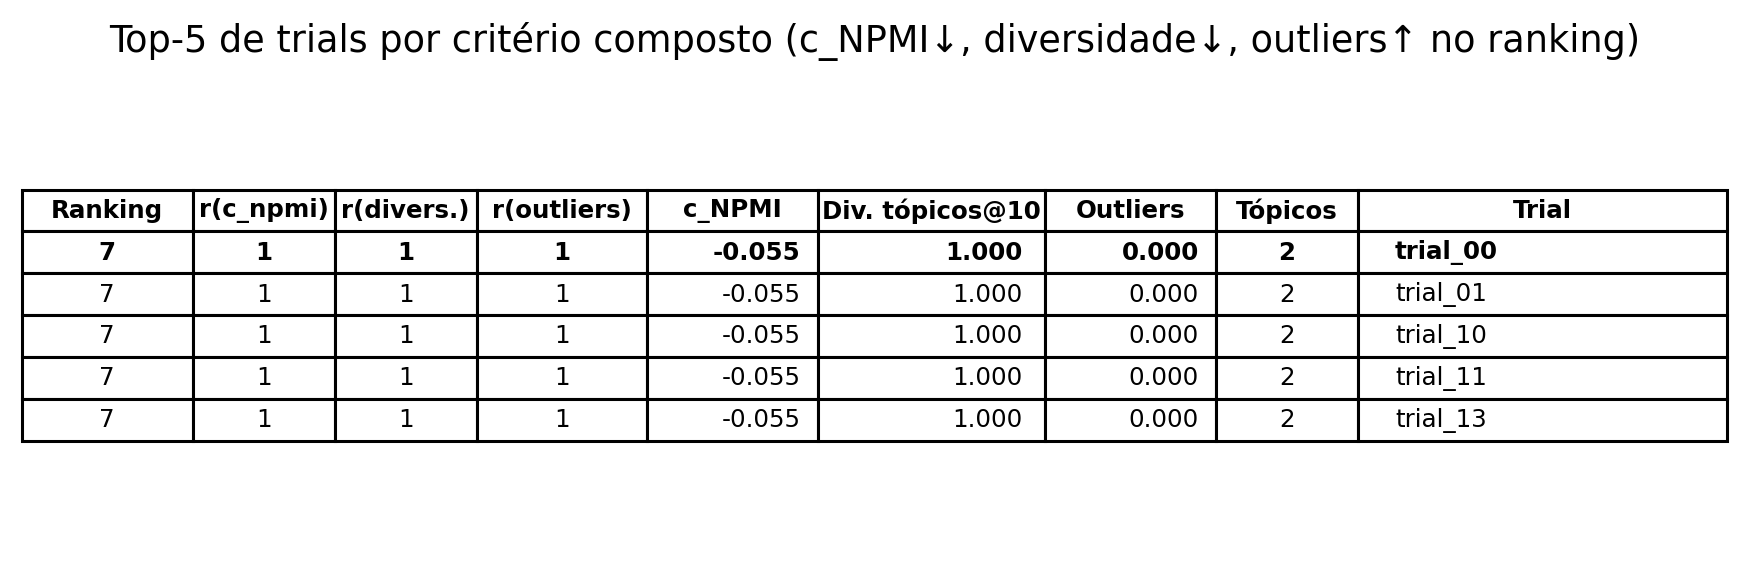

In [ ]:
# --- Exporta TOP-5 do ranking composto como imagem PNG (tabela para o artigo) ---
# Requer: df_rank já definido acima.
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

OUT_DIR = Path("../../data/interim/quality")
OUT_DIR.mkdir(parents=True, exist_ok=True)
PNG_PATH = OUT_DIR / "top5_trials_rank_composto.png"

# Seleção e formatação
k = min(5, len(df_rank))
top = df_rank.head(k).copy()

# Ordenação de colunas para publicação
col_order = ["rank_sum", "r1", "r2", "r3", "c_npmi", "topic_diversity", "outlier_rate", "n_topics", "trial_id"]
top = top[col_order].rename(columns={
    "rank_sum": "Ranking",
    "r1": "r(c_npmi)",
    "r2": "r(divers.)",
    "r3": "r(outliers)",
    "c_npmi": "c_NPMI",
    "topic_diversity": "Div. tópicos@10",
    "outlier_rate": "Outliers",
    "n_topics": "Tópicos",
    "trial_id": "Trial"
})

# Formatação de casas decimais
def fmt_num(x, nd=3):
    try:
        return f"{float(x):.{nd}f}"
    except Exception:
        return str(x)

top["c_NPMI"] = top["c_NPMI"].map(lambda v: fmt_num(v, 3))
top["Div. tópicos@10"] = top["Div. tópicos@10"].map(lambda v: fmt_num(v, 3))
top["Outliers"] = top["Outliers"].map(lambda v: fmt_num(v, 3))
top["Ranking"] = top["Ranking"].astype(int)
top["r(c_npmi)"] = top["r(c_npmi)"].astype(int)
top["r(divers.)"] = top["r(divers.)"].astype(int)
top["r(outliers)"] = top["r(outliers)"].astype(int)
top["Tópicos"] = top["Tópicos"].astype(int)

# Renderização como PNG
fig_w = 8.0
fig_h = 0.8 + 0.32 * (k + 1)  # +1 para o cabeçalho
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=220)
ax.axis("off")
ax.set_title("Os 5 melhores trials por critério composto (c_NPMI, diversidade, outliers no ranking)", pad=8)

# Dados para a tabela
cell_text = top.values.tolist()
col_labels = list(top.columns)

# Larguras relativas das colunas (ajuste fino se quiser)
col_widths = [0.12, 0.10, 0.10, 0.12, 0.12, 0.16, 0.12, 0.10, 0.26]

tbl = ax.table(cellText=cell_text, colLabels=col_labels, loc="center", colWidths=col_widths)

# Estilo
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.0, 1.1)

# Alinhamentos por coluna
numeric_center = {"Ranking", "r(c_npmi)", "r(divers.)", "r(outliers)", "Tópicos"}
numeric_right  = {"c_NPMI", "Div. tópicos@10", "Outliers"}
for (r, c), cell in tbl.get_celld().items():
    if r == 0:
        cell.set_text_props(weight="bold", ha="center", va="center")
    else:
        col_name = col_labels[c]
        if col_name in numeric_center:
            cell.set_text_props(ha="center", va="center")
        elif col_name in numeric_right:
            cell.set_text_props(ha="right", va="center")
        else:  # Trial
            cell.set_text_props(ha="left", va="center")
        # destaca a melhor (primeira linha de dados)
        if r == 1:
            cell.set_text_props(weight="bold")

fig.tight_layout()
fig.savefig(PNG_PATH, bbox_inches="tight")
plt.close(fig)

print("Tabela TOP-5 salva em:", PNG_PATH)

# Exibição rápida no notebook
from IPython.display import Image, display
display(Image(filename=str(PNG_PATH)))